In [1]:
from data_reader_writer import *
import itertools as it
import pandas as pd
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, ElasticNetCV, SGDClassifier, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline

In [2]:
ephys_data = load_ephys_data()
gamble_choices = load_gamble_choices_data()
behavior_data = load_behavior_data()
regressor_data = load_regressor_data()

In [67]:
gamble_choices.head()

,Safe.Bet.Amount,Risky.Bet.Amount,Risky.bet.shown.number,Risky.bet.hidden.number,Risky.Side
0,10,30,1,5,Left
1,10,20,4,5,Left
2,10,25,7,8,Right
3,10,30,1,4,Left
4,10,25,6,1,Left


In [9]:
sub1_ephys = ephys_data["s1"]
sub1_behavior = behavior_data["s1"]
sub1_behavior.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
0,1,6.191,6.957,8.003,8.019,8.535,Left,Gamble,Win,1
1,2,9.550,10.316,11.441,11.457,11.972,Left,Gamble,Win,1
2,3,12.988,13.753,14.832,14.847,15.363,Left,Safebet,WouldHaveWon,1
3,4,16.378,17.144,18.144,18.175,18.691,Left,Gamble,Win,1
4,5,19.707,20.472,21.519,21.550,22.066,Right,Safebet,WouldHaveLost,1


In [10]:
df = pd.concat([sub1_behavior, gamble_choices[["Risky.Bet.Amount", "Risky.bet.shown.number"]]], axis=1)
df.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included,Risky.Bet.Amount,Risky.bet.shown.number
0,1,6.191,6.957,8.003,8.019,8.535,Left,Gamble,Win,1,30,1
1,2,9.550,10.316,11.441,11.457,11.972,Left,Gamble,Win,1,20,4
2,3,12.988,13.753,14.832,14.847,15.363,Left,Safebet,WouldHaveWon,1,25,7
3,4,16.378,17.144,18.144,18.175,18.691,Left,Gamble,Win,1,30,1
4,5,19.707,20.472,21.519,21.550,22.066,Right,Safebet,WouldHaveLost,1,25,6


In [11]:
df['choice.class'].value_counts()

Gamble     124
Safebet     72
Timeout      4
Name: choice.class, dtype: int64

In [12]:
X = df[df['choice.class'] != 'Timeout'][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
X.head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,30,1
1,20,4
2,25,7
3,30,1
4,25,6


In [13]:
X_norm = (X - X.mean()) / (X.max() - X.min())
X_norm.head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,0.505102,-0.383163
1,-0.161565,-0.083163
2,0.171769,0.216837
3,0.505102,-0.383163
4,0.171769,0.116837


In [14]:
df = X['Risky.Bet.Amount']
df_norm = (df - df.mean()) / (df.max() - df.min())

In [15]:
sub1_behavior[sub1_behavior['choice.class'] == 'Timeout']

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
11,12,44.832,45.597,NaN,47.613,48.128,Timeout,Timeout,Timeout,0
15,16,60.597,61.363,NaN,63.378,63.894,Timeout,Timeout,Timeout,0
110,111,402.800,403.566,NaN,405.582,406.097,Timeout,Timeout,Timeout,0
156,157,562.253,563.019,NaN,565.035,565.550,Timeout,Timeout,Timeout,0


In [16]:
idx = sub1_behavior[sub1_behavior['choice.class'] == 'Timeout'].index
idx

Int64Index([11, 15, 110, 156], dtype='int64')

In [17]:
sub1_behavior.iloc[idx]

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
11,12,44.832,45.597,NaN,47.613,48.128,Timeout,Timeout,Timeout,0
15,16,60.597,61.363,NaN,63.378,63.894,Timeout,Timeout,Timeout,0
110,111,402.800,403.566,NaN,405.582,406.097,Timeout,Timeout,Timeout,0
156,157,562.253,563.019,NaN,565.035,565.550,Timeout,Timeout,Timeout,0


In [3]:
def make_data(subjects=SUBJECTS):
    data = {}
    for s in subjects:
        behav = behavior_data[s]
        non_timeout_idx = behav[behav['choice.class'] != 'Timeout'].index
        X = gamble_choices.iloc[non_timeout_idx][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
        y = behav.iloc[non_timeout_idx]['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        data[s] = (X, y)
    return data

In [4]:
def make_normalized_data(subjects=SUBJECTS):
    data = {}
    for s in subjects:
        behav = behavior_data[s]
        non_timeout_idx = behav[behav['choice.class'] != 'Timeout'].index
        X = gamble_choices.iloc[non_timeout_idx][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
        y = behav.iloc[non_timeout_idx]['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        X_norm = (X - X.mean()) / (X.max() - X.min()) # normalize data
        data[s] = (X_norm, y)
    return data

In [5]:
def normalize(data):
    return (data - data.mean()) / (data.max() - data.min())

In [6]:
data = make_data()

In [7]:
data_norm = make_normalized_data()

In [23]:
data['s1'][0].head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,30,1
1,20,4
2,25,7
3,30,1
4,25,6


In [86]:
type(sub1_ephys['buttonpress_events_hg']) == np.ndarray

True

In [24]:
data_norm['s1'][0].head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,0.505102,-0.383163
1,-0.161565,-0.083163
2,0.171769,0.216837
3,0.505102,-0.383163
4,0.171769,0.116837


In [81]:
type(data_norm['s1'][0]) == pd.core.frame.DataFrame

True

In [25]:
X, y = data['s9']
logr = LogisticRegression()
print("LogisticRegression", cross_val_score(logr, X, y, cv=5)) 
lasso = LassoCV()
print("LassoCV", cross_val_score(lasso, X, y, cv=5)) 
ridge = RidgeCV()
print("RidgeCV", cross_val_score(ridge, X, y, cv=5)) 
linsvc = LinearSVC()
print("LinearSVC", cross_val_score(linsvc, X, y, cv=5))
nusvc = NuSVC()
print("NuSVC", cross_val_score(nusvc, X, y, cv=5))
svc = SVC()
print("SVC", cross_val_score(svc, X, y, cv=5))
dt = DecisionTreeClassifier()
print("DecisionTreeClassifier", cross_val_score(dt, X, y, cv=5))
edt = ExtraTreeClassifier()
print("ExtraTreeClassifier", cross_val_score(edt, X, y, cv=5))
rf = RandomForestClassifier()
print("RandomForestClassifier", cross_val_score(rf, X, y, cv=5))
enet = ElasticNetCV()
print("ElasticNetCV", cross_val_score(enet, X, y, cv=5))
sgd = SGDClassifier()
print("SGDClassifier", cross_val_score(sgd, X, y, cv=5))

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

LogisticRegression [0.85  0.75  0.7   0.925 0.85 ]


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on t

LassoCV [0.58823906 0.48156191 0.27773411 0.63145393 0.59726858]
RidgeCV [0.58790851 0.4817875  0.27912191 0.63098886 0.59660411]


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

LinearSVC [0.8  0.85 0.75 0.95 0.85]
NuSVC [0.9   0.825 0.7   0.975 0.875]


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:196:

SVC [0.9   0.825 0.7   0.975 0.875]
DecisionTreeClassifier [0.9  0.8  0.7  0.95 0.85]
ExtraTreeClassifier [0.9  0.8  0.7  0.95 0.85]


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\ensemble\f

RandomForestClassifier [0.925 0.825 0.7   0.975 0.875]


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGD

ElasticNetCV [0.58823285 0.48156661 0.27784843 0.63144598 0.59718059]
SGDClassifier [0.65 0.75 0.65 0.85 0.6 ]


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [8]:
LR = "LogisticRegression"
LASSO = "LassoCV"
RIDGE = "RidgeCV"
LSVC = "LinearSVC"
NUSVC = "NuSVC"
SVC = "SVC"
ELNET = "ElasticNetCV"
SGD = "SGDClassifier"
MODELS = [LR, LASSO, RIDGE, LSVC, NUSVC, SVC, ELNET, SGD]

In [22]:
np.array([[1,2], [3,4]]).mean(axis=0)

A = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
b = np.array([1, 2, 3, 4])
kf = KFold(n_splits=4)
for i1, i2 in kf.split(A):
    print(i1, i2)

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [31]:
sgd = SGDClassifier()
sgd.fit(X, y)
y_pred = sgd.predict(X)
precision_recall_fscore_support(y, y_pred, average='weighted')

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


(0.8083623693379792, 0.8, 0.7974296205630356, None)

In [9]:
def cross_validation(X, y, model, k=5):
    test_accuracies = []
    train_accuracies = []
    test_metrics = []
    train_metrics = []
    X_weights = []
    kf = KFold(n_splits=k)
    
    for idx_tr, idx_te in kf.split(X):
        if type(X) == pd.core.frame.DataFrame:
            X_train = X.iloc[idx_tr]
            y_train = y.iloc[idx_tr]

            X_test = X.iloc[idx_te]
            y_test = y.iloc[idx_te]
        elif type(X) == np.ndarray:
            X_train = X[idx_tr]
            y_train = y[idx_tr]

            X_test = X[idx_te]
            y_test = y[idx_te]
        
        if model == LR:
            logr = LogisticRegression()
            logr.fit(X_train, y_train)
            y_test_pred = logr.predict(X_test)
            y_train_pred = logr.predict(X_train)
            X_weights.append(logr.coef_)
        
        elif model == LSVC:
            lsvc = LinearSVC()
            lsvc.fit(X_train, y_train)
            y_test_pred = lsvc.predict(X_test)
            y_train_pred = lsvc.predict(X_train)
            X_weights.append(lsvc.coef_)
        
        test_accuracies.append(accuracy_score(y_test, y_test_pred))
        train_accuracies.append(accuracy_score(y_train, y_train_pred))
        test_metrics.append(precision_recall_fscore_support(y_test, y_test_pred, average='weighted')[:3]) # exclude support
        train_metrics.append(precision_recall_fscore_support(y_train, y_train_pred, average='weighted')[:3])
        
#         elif model == NUSVC:
#             nusvc = NuSVC()
#             nusvc.fit(X_train, y_train)
#             test_accuracies.append(nusvc.score(X_test, y_test))
#             train_accuracies.append(nusvc.score(X_train, y_train))
#             X_weights.append(nusvc.coef_)  # coef_ only available with a linear kernel
    
    mean_test = round(np.array(test_accuracies).mean(), 3)
    mean_train = round(np.array(train_accuracies).mean(), 3)
    # metrics -- 3 floats: precision, recall, f-score
    mean_test_metrics = np.array(test_metrics).mean(axis=0)
    mean_train_metrics = np.array(train_metrics).mean(axis=0)
    
    return np.array(X_weights).mean(axis=0)[0], mean_test, mean_train, mean_test_metrics, mean_train_metrics

In [37]:
np.array([(0,1,2), (4,5,6)]).mean(axis=0)

array([2., 3., 4.])

In [10]:
def test_models(data, models):
    results = defaultdict(dict)
    for m in models:
        mean_coefs = []
        test_accs = []
        train_accs = []
        test_fscores = []
        train_fscores = []
        test_precisions = []
        train_precisions = []
        test_recalls = []
        train_recalls = []
        for s in SUBJECTS:
            X, y = data[s]
            print("Subject", s)
            coefs, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, m)
            mean_coefs.append(coefs)
            test_accs.append(mean_test)
            train_accs.append(mean_train)
            test_precisions.append(mean_test_metrics[0])
            train_precisions.append(mean_train_metrics[0])
            test_recalls.append(mean_test_metrics[1])
            train_recalls.append(mean_train_metrics[1])
            test_fscores.append(mean_test_metrics[2])
            train_fscores.append(mean_train_metrics[2])
            
            print("Model %s, mean test acc %f, train acc %f, mean test f-score %f, train f-score %f" % 
                  (m, mean_test, mean_train, mean_test_metrics[2], mean_train_metrics[2]))
            
        results[m]["mean_coefs"] = mean_coefs
        results[m]["test_accs"] = test_accs
        results[m]["train_accs"] = train_accs
        results[m]["test_f-scores"] = test_fscores
        results[m]["train_f-scores"] = train_fscores
        results[m]["test_precisions"] = test_precisions
        results[m]["train_precisions"] = train_precisions
        results[m]["test_recalls"] = test_recalls
        results[m]["train_recalls"] = train_recalls

    return results

In [11]:
results = test_models(data, [LR, LSVC])

Subject s1
Model LogisticRegression, mean test acc 0.786000, train acc 0.782000, mean test f-score 0.782797, train f-score 0.779810
Subject s2


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

Model LogisticRegression, mean test acc 0.879000, train acc 0.893000, mean test f-score 0.878749, train f-score 0.892715
Subject s3
Model LogisticRegression, mean test acc 0.690000, train acc 0.696000, mean test f-score 0.689365, train f-score 0.695696
Subject s4


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.

Model LogisticRegression, mean test acc 0.389000, train acc 0.532000, mean test f-score 0.356665, train f-score 0.482717
Subject s5
Model LogisticRegression, mean test acc 0.699000, train acc 0.739000, mean test f-score 0.607970, train f-score 0.645905
Subject s6


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

Model LogisticRegression, mean test acc 0.895000, train acc 0.895000, mean test f-score 0.894373, train f-score 0.895035
Subject s7
Model LogisticRegression, mean test acc 0.865000, train acc 0.876000, mean test f-score 0.863280, train f-score 0.875859
Subject s8


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

Model LogisticRegression, mean test acc 0.680000, train acc 0.691000, mean test f-score 0.684578, train f-score 0.690442
Subject s9
Model LogisticRegression, mean test acc 0.805000, train acc 0.825000, mean test f-score 0.801678, train f-score 0.824336
Subject s10


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

Model LogisticRegression, mean test acc 0.529000, train acc 0.600000, mean test f-score 0.436499, train f-score 0.510625
Subject s1


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.694000, train acc 0.705000, mean test f-score 0.675892, train f-score 0.694092
Subject s2
Model LinearSVC, mean test acc 0.879000, train acc 0.890000, mean test f-score 0.878398, train f-score 0.888077
Subject s3


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.615000, train acc 0.634000, mean test f-score 0.591096, train f-score 0.608494
Subject s4
Model LinearSVC, mean test acc 0.371000, train acc 0.538000, mean test f-score 0.233523, train f-score 0.386595
Subject s5


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

Model LinearSVC, mean test acc 0.734000, train acc 0.735000, mean test f-score 0.627171, train f-score 0.622618
Subject s6


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.915000, train acc 0.912000, mean test f-score 0.915209, train f-score 0.911291
Subject s7


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.850000, train acc 0.870000, mean test f-score 0.848447, train f-score 0.867821
Subject s8


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.675000, train acc 0.700000, mean test f-score 0.655778, train f-score 0.689468
Subject s9
Model LinearSVC, mean test acc 0.780000, train acc 0.786000, mean test f-score 0.771149, train f-score 0.775746
Subject s10


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.520000, train acc 0.538000, mean test f-score 0.398346, train f-score 0.420320


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\si

In [57]:
results_norm = test_models(data_norm, [LR, LSVC])

Subject s1
Model LogisticRegression, mean test acc 0.791000, train acc 0.804000, mean test f-score 0.781965, train f-score 0.797938
Subject s2


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

Model LogisticRegression, mean test acc 0.919000, train acc 0.919000, mean test f-score 0.918950, train f-score 0.918913
Subject s3
Model LogisticRegression, mean test acc 0.670000, train acc 0.705000, mean test f-score 0.670470, train f-score 0.704279
Subject s4


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Model LogisticRegression, mean test acc 0.417000, train acc 0.556000, mean test f-score 0.380009, train f-score 0.510818
Subject s5
Model LogisticRegression, mean test acc 0.724000, train acc 0.737000, mean test f-score 0.622066, train f-score 0.633877
Subject s6


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

Model LogisticRegression, mean test acc 0.915000, train acc 0.921000, mean test f-score 0.913913, train f-score 0.920891
Subject s7
Model LogisticRegression, mean test acc 0.905000, train acc 0.908000, mean test f-score 0.904641, train f-score 0.907325
Subject s8


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

Model LogisticRegression, mean test acc 0.675000, train acc 0.706000, mean test f-score 0.679209, train f-score 0.704694
Subject s9
Model LogisticRegression, mean test acc 0.835000, train acc 0.834000, mean test f-score 0.833470, train f-score 0.833383
Subject s10


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.

Model LogisticRegression, mean test acc 0.543000, train acc 0.600000, mean test f-score 0.447621, train f-score 0.509336
Subject s1
Model LinearSVC, mean test acc 0.796000, train acc 0.796000, mean test f-score 0.791306, train f-score 0.792992
Subject s2
Model LinearSVC, mean test acc 0.924000, train acc 0.924000, mean test f-score 0.924072, train f-score 0.924088
Subject s3
Model LinearSVC, mean test acc 0.680000, train acc 0.708000, mean test f-score 0.680384, train f-score 0.706954
Subject s4
Model LinearSVC, mean test acc 0.398000, train acc 0.561000, mean test f-score 0.375457, train f-score 0.522359
Subject s5


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

Model LinearSVC, mean test acc 0.709000, train acc 0.745000, mean test f-score 0.613853, train f-score 0.648399
Subject s6
Model LinearSVC, mean test acc 0.935000, train acc 0.935000, mean test f-score 0.934825, train f-score 0.935042
Subject s7
Model LinearSVC, mean test acc 0.900000, train acc 0.909000, mean test f-score 0.899469, train f-score 0.908580
Subject s8
Model LinearSVC, mean test acc 0.680000, train acc 0.711000, mean test f-score 0.685053, train f-score 0.710268
Subject s9
Model LinearSVC, mean test acc 0.840000, train acc 0.838000, mean test f-score 0.838872, train f-score 0.837219
Subject s10
Model LinearSVC, mean test acc 0.521000, train acc 0.592000, mean test f-score 0.439043, train f-score 0.511469


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

In [12]:
# metric -- 'accs', 'precisions', 'recalls', 'f-scores'
def plot_model_metrics(results, metric="accs", plot_title=None):
    rows = round(len(results) / 2)
    fig, axes = plt.subplots(rows, 2, figsize=(10, 3 * rows))
    axes = axes.flatten()
    
    models = list(results.keys())
    test_key = "test_" + metric
    train_key = "train_" + metric
    ylabel = metric[:-1] if metric != "accs" else "accuracy"
    title = metric if metric != "accs" else "accuracies"
    for i in range(len(results)):
        m = models[i] # model name
        data = pd.DataFrame({"subject": SUBJECTS + SUBJECTS, "metric": results[m][test_key] + results[m][train_key], 
                                 "type": np.append(np.repeat("test", len(SUBJECTS)), np.repeat("train", len(SUBJECTS)))})
        sns.pointplot(x="subject", y="metric", hue="type", data=data, dodge=True, ax=axes[i]).set(
            title=m + " " + title, ylabel=ylabel)
    
    if plot_title != None:
        save_fig(fig, plot_title)

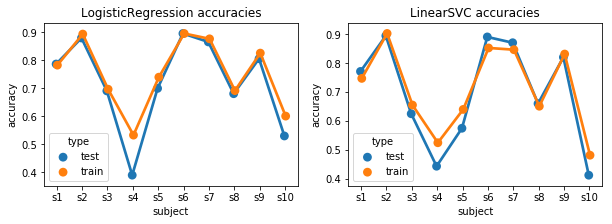

In [61]:
plot_model_metrics(results, plot_title="LR_LSVC_accs")

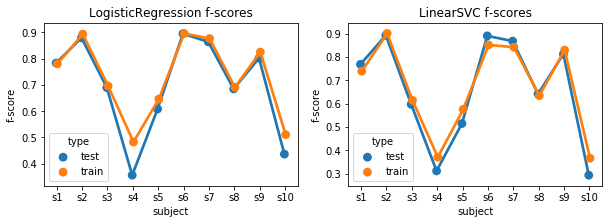

In [62]:
plot_model_metrics(results, metric="f-scores", plot_title="LR_LSVC_fscores")

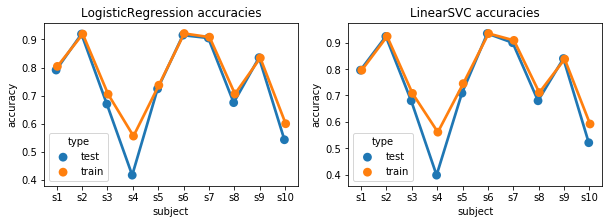

In [63]:
plot_model_metrics(results_norm, plot_title="LR_LSVC_accs_norm")

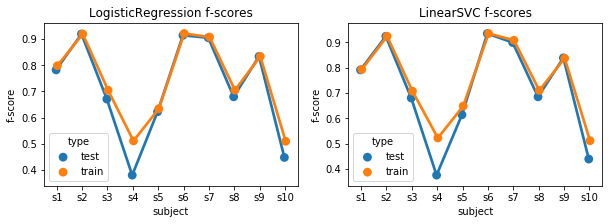

In [64]:
plot_model_metrics(results_norm, metric="f-scores", plot_title="LR_LSVC_fscores_norm")

In [13]:
def plot_model_coefs(results, plot_title=None):
    rows = round(len(results) / 2)
    fig, axes = plt.subplots(rows, 2, figsize=(10, 3 * rows))
    axes = axes.flatten()
    
    models = list(results.keys())
    for i in range(len(results)):
        m = models[i] # model name

        data = pd.DataFrame({"prize_coef": np.array(results[m]["mean_coefs"])[:, 0],
                                "rnd_nr_coef": np.array(results[m]["mean_coefs"])[:, 1], 
                                "subject": SUBJECTS}) 
        sns.scatterplot(x="prize_coef", y="rnd_nr_coef", hue="subject", data=data, ax=axes[i]).set(
            title="%s coefs" % m)

        # Show only one legend 
        if i < len(results) - 1:
            axes[i].legend().remove()
        else:
            axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if plot_title != None:
        save_fig(fig, plot_title)

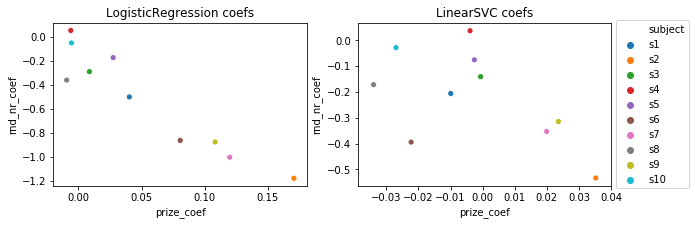

In [66]:
plot_model_coefs(results, "LR_LSVC_coefs")

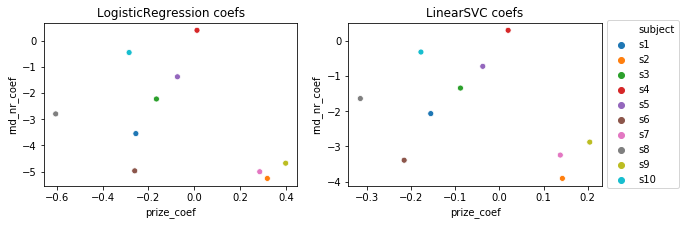

In [67]:
plot_model_coefs(results_norm, "LR_LSVC_coefs_norm")

In [14]:
all_datasets = load_var("all_datasets_1")

In [69]:
regressor_data['s9']['gamble_ind'].flatten()#[[1, 3, 5]]

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0], dtype=uint8)

In [16]:
dataset_1 = all_datasets[('s9', GAMEPRES_BUTTONPRESS, ALL, 2, True)]
y1 = regressor_data['s9']['gamble_ind'].flatten()

In [17]:
logr = LogisticRegression(solver="liblinear")
print("LogisticRegression", np.array(cross_val_score(logr, normalize(dataset_1), y1, cv=5)).mean()) 

LogisticRegression 0.5199999999999999


In [72]:
y2 = regressor_data['s9']['winprob'].flatten()

In [73]:
# linreg = LinearRegression()
svr = LinearSVR()
print(np.array(cross_val_score(svr, normalize(dataset_1), y2, cv=5)).mean())

-0.13568137396224395


In [18]:
regression_results = defaultdict(lambda: defaultdict(dict))

for key in all_datasets:
    s, tw_type, trial_type, _, _ = key
    
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    s_behav = s_behav.reset_index(drop=True)
    
    indices = None
    if trial_type == ALL:
        indices = s_behav.index
#     elif trial_type == LOSS:
#         indices = s_behav[s_behav['outcome'] == 'Loss'].index
#     elif trial_type == WIN:
#         indices = s_behav[s_behav['outcome'] == 'Win'].index
#     elif trial_type == GAMBLE:
#         indices = s_behav[s_behav['choice.class'] == 'Gamble'].index
    else:
        continue
        
    assert len(indices) == len(all_datasets[key]), "Lengths do not correspond!"
    
    X = normalize(all_datasets[key])
    if tw_type == GAMEPRES_BUTTONPRESS:
#         for regr in ["exputil", "risk", "winprob"]:
#             y = regressor_data[s][regr].flatten()[indices]
#             linreg = LinearRegression()
#             score = np.array(cross_val_score(linreg, X, y, cv=5)).mean()
#             regression_results[key][regr] = score
            
        y = regressor_data[s]["gamble_ind"].flatten()[indices]
#         logr = LogisticRegression(solver="liblinear")
#         score = np.array(cross_val_score(logr, X, y, cv=5)).mean()
        _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LR)
        regression_results[key]["gamble_ind"][LR] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
        _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LSVC)
        regression_results[key]["gamble_ind"][LSVC] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
        
    else:
        for regr in ["loss_ind", "regret", "win_ind"]:
            y = regressor_data[s][regr].flatten()[indices]
#             score = np.array(cross_val_score(logr, X, y, cv=5)).mean()
#             regression_results[key][regr] = score
            _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LR)
            regression_results[key][regr][LR] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
            _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LSVC)
            regression_results[key][regr][LSVC] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
        
#         y = regressor_data[s]["rpe"].flatten()[indices]
#         linreg = LinearRegression()
#         score = np.array(cross_val_score(linreg, X, y, cv=5)).mean()
#         regression_results[key]["rpe"] = score

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will b

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-pack

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision 

In [19]:
a = [1,2,3]
a[0] += 1
a

[2, 2, 3]

In [31]:
b = [0, 0]
test = defaultdict(lambda: defaultdict(lambda: b)) 
l = test['a']['b']
l[0] += 1
test['a']['b'] = l
test

defaultdict(<function __main__.<lambda>()>,
            {'a': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'b': [1, 0]})})

In [32]:
m = test['a']['c']
m[1] += 1
test['a']['c'] = m
test

defaultdict(<function __main__.<lambda>()>,
            {'a': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'b': [1, 1], 'c': [1, 1]})})

In [21]:
regression_results[list(regression_results.keys())[0]]['loss_ind']

{'LogisticRegression': (0.794,
  0.794,
  array([0.63410494, 0.79444444, 0.70449992]),
  array([0.63132716, 0.79444444, 0.70350358])),
 'LinearSVC': (0.8,
  0.8,
  array([0.67140653, 0.8       , 0.71635473]),
  array([0.79738079, 0.8       , 0.71643921]))}

In [70]:
result_statistics_LR = defaultdict(lambda: defaultdict(lambda: np.array([0.0, 0.0, 0.0, 0.0]))) 
counts = defaultdict(lambda: defaultdict(int))
result_statistics_LSVC = defaultdict(lambda: defaultdict(lambda: np.array([0.0, 0.0, 0.0, 0.0])))
# keys for result statistics: 'regressor', 'subject', 'tw_type', 'trial_type', 'use_all_els'
# 2nd layer keys: different param values
# results_statistics[param][param_value] = [mean test acc, mean test precision, mean test recall, mean test f-score]


for key1 in regression_results:
    s, tw_type, trial_type, tw_per_el, use_all_els = key1
    
    for key2 in regression_results[key1]:
        test_acc_LR = regression_results[key1][key2][LR][0]
        test_acc_LSVC = regression_results[key1][key2][LSVC][0]
        test_metrics_LR = regression_results[key1][key2][LR][2]
        test_metrics_LSVC = regression_results[key1][key2][LSVC][2]
        
        counts['combo'][key1] += 1
        result_statistics_LR['combo'][key1][0] += test_acc_LR
        result_statistics_LSVC['combo'][key1][0] += test_acc_LSVC
        result_statistics_LR['combo'][key1][1] += test_metrics_LR[0]
        result_statistics_LSVC['combo'][key1][1] += test_metrics_LSVC[0]
        result_statistics_LR['combo'][key1][2] += test_metrics_LR[1]
        result_statistics_LSVC['combo'][key1][2] += test_metrics_LSVC[1]
        result_statistics_LR['combo'][key1][3] += test_metrics_LR[2]
        result_statistics_LSVC['combo'][key1][3] += test_metrics_LSVC[2]
        
        counts['regressor'][key2] += 1
        result_statistics_LR['regressor'][key2][0] += test_acc_LR
        result_statistics_LSVC['regressor'][key2][0] += test_acc_LSVC
        result_statistics_LR['regressor'][key2][1] += test_metrics_LR[0]
        result_statistics_LSVC['regressor'][key2][1] += test_metrics_LSVC[0]
        result_statistics_LR['regressor'][key2][2] += test_metrics_LR[1]
        result_statistics_LSVC['regressor'][key2][2] += test_metrics_LSVC[1]
        result_statistics_LR['regressor'][key2][3] += test_metrics_LR[2]
        result_statistics_LSVC['regressor'][key2][3] += test_metrics_LSVC[2]
        
        counts['subject'][s] += 1
        result_statistics_LR['subject'][s][0] += test_acc_LR
        result_statistics_LSVC['subject'][s][0] += test_acc_LSVC
        result_statistics_LR['subject'][s][1] += test_metrics_LR[0]
        result_statistics_LSVC['subject'][s][1] += test_metrics_LSVC[0]
        result_statistics_LR['subject'][s][2] += test_metrics_LR[1]
        result_statistics_LSVC['subject'][s][2] += test_metrics_LSVC[1]
        result_statistics_LR['subject'][s][3] += test_metrics_LR[2]
        result_statistics_LSVC['subject'][s][3] += test_metrics_LSVC[2]
        
        counts['tw_type'][tw_type] += 1
        result_statistics_LR['tw_type'][tw_type][0] += test_acc_LR
        result_statistics_LSVC['tw_type'][tw_type][0] += test_acc_LSVC
        result_statistics_LR['tw_type'][tw_type][1] += test_metrics_LR[0]
        result_statistics_LSVC['tw_type'][tw_type][1] += test_metrics_LSVC[0]
        result_statistics_LR['tw_type'][tw_type][2] += test_metrics_LR[1]
        result_statistics_LSVC['tw_type'][tw_type][2] += test_metrics_LSVC[1]
        result_statistics_LR['tw_type'][tw_type][3] += test_metrics_LR[2]
        result_statistics_LSVC['tw_type'][tw_type][3] += test_metrics_LSVC[2]
        
        counts['trial_type'][trial_type] += 1
        result_statistics_LR['trial_type'][trial_type][0] += test_acc_LR
        result_statistics_LSVC['trial_type'][trial_type][0] += test_acc_LSVC
        result_statistics_LR['trial_type'][trial_type][1] += test_metrics_LR[0]
        result_statistics_LSVC['trial_type'][trial_type][1] += test_metrics_LSVC[0]
        result_statistics_LR['trial_type'][trial_type][2] += test_metrics_LR[1]
        result_statistics_LSVC['trial_type'][trial_type][2] += test_metrics_LSVC[1]
        result_statistics_LR['trial_type'][trial_type][3] += test_metrics_LR[2]
        result_statistics_LSVC['trial_type'][trial_type][3] += test_metrics_LSVC[2]
        
        counts['tw_per_el'][tw_per_el] += 1
        result_statistics_LR['tw_per_el'][tw_per_el][0] += test_acc_LR
        result_statistics_LSVC['tw_per_el'][tw_per_el][0] += test_acc_LSVC
        result_statistics_LR['tw_per_el'][tw_per_el][1] += test_metrics_LR[0]
        result_statistics_LSVC['tw_per_el'][tw_per_el][1] += test_metrics_LSVC[0]
        result_statistics_LR['tw_per_el'][tw_per_el][2] += test_metrics_LR[1]
        result_statistics_LSVC['tw_per_el'][tw_per_el][2] += test_metrics_LSVC[1]
        result_statistics_LR['tw_per_el'][tw_per_el][3] += test_metrics_LR[2]
        result_statistics_LSVC['tw_per_el'][tw_per_el][3] += test_metrics_LSVC[2]
        
        counts['use_all_els'][use_all_els] += 1
        result_statistics_LR['use_all_els'][use_all_els][0] += test_acc_LR
        result_statistics_LSVC['use_all_els'][use_all_els][0] += test_acc_LSVC
        result_statistics_LR['use_all_els'][use_all_els][1] += test_metrics_LR[0]
        result_statistics_LSVC['use_all_els'][use_all_els][1] += test_metrics_LSVC[0]
        result_statistics_LR['use_all_els'][use_all_els][2] += test_metrics_LR[1]
        result_statistics_LSVC['use_all_els'][use_all_els][2] += test_metrics_LSVC[1]
        result_statistics_LR['use_all_els'][use_all_els][3] += test_metrics_LR[2]
        result_statistics_LSVC['use_all_els'][use_all_els][3] += test_metrics_LSVC[2]
        
for key1 in result_statistics_LR:
    for key2 in result_statistics_LR[key1]:
        result_statistics_LR[key1][key2] /= counts[key1][key2]
        result_statistics_LR[key1][key2] = np.round(result_statistics_LR[key1][key2], 3)
        result_statistics_LSVC[key1][key2] /= counts[key1][key2]
        result_statistics_LSVC[key1][key2] = np.round(result_statistics_LSVC[key1][key2], 3)

In [71]:
sorted(result_statistics_LR['regressor'].items(), key=lambda x: x[1][3], reverse=True)

[('loss_ind', array([0.816, 0.678, 0.816, 0.738])),
 ('win_ind', array([0.636, 0.461, 0.636, 0.514])),
 ('regret', array([0.625, 0.435, 0.625, 0.502])),
 ('gamble_ind', array([0.552, 0.483, 0.552, 0.472]))]

In [56]:
sorted(result_statistics_LSVC['regressor'].items(), key=lambda x: x[1][3], reverse=True)

[('loss_ind', array([0.814, 0.688, 0.814, 0.739])),
 ('win_ind', array([0.629, 0.549, 0.629, 0.549])),
 ('regret', array([0.621, 0.477, 0.621, 0.52 ])),
 ('gamble_ind', array([0.557, 0.521, 0.557, 0.505]))]

In [57]:
sorted(result_statistics_LR['subject'].items(), key=lambda x: x[1][3], reverse=True)

[('s9', array([0.692, 0.623, 0.692, 0.626])),
 ('s7', array([0.676, 0.555, 0.676, 0.588])),
 ('s3', array([0.669, 0.538, 0.669, 0.581])),
 ('s2', array([0.68 , 0.537, 0.681, 0.579])),
 ('s6', array([0.687, 0.508, 0.687, 0.57 ])),
 ('s8', array([0.646, 0.561, 0.646, 0.562])),
 ('s1', array([0.669, 0.459, 0.669, 0.541])),
 ('s5', array([0.642, 0.445, 0.642, 0.514])),
 ('s4', array([0.594, 0.474, 0.593, 0.509])),
 ('s10', array([0.618, 0.44 , 0.618, 0.495]))]

In [58]:
sorted(result_statistics_LSVC['subject'].items(), key=lambda x: x[1][3], reverse=True)

[('s9', array([0.699, 0.636, 0.699, 0.648])),
 ('s2', array([0.686, 0.594, 0.686, 0.614])),
 ('s7', array([0.666, 0.574, 0.666, 0.599])),
 ('s3', array([0.654, 0.57 , 0.654, 0.597])),
 ('s8', array([0.651, 0.578, 0.651, 0.586])),
 ('s6', array([0.682, 0.533, 0.682, 0.573])),
 ('s5', array([0.633, 0.533, 0.633, 0.55 ])),
 ('s1', array([0.665, 0.479, 0.665, 0.543])),
 ('s4', array([0.605, 0.537, 0.605, 0.537])),
 ('s10', array([0.61 , 0.554, 0.61 , 0.537]))]

In [59]:
sorted(result_statistics_LR['trial_type'].items(), key=lambda x: x[1][3], reverse=True)

[('all', array([0.657, 0.514, 0.657, 0.557]))]

In [60]:
sorted(result_statistics_LSVC['trial_type'].items(), key=lambda x: x[1][3], reverse=True)

[('all', array([0.655, 0.559, 0.655, 0.579]))]

In [61]:
sorted(result_statistics_LR['tw_type'].items(), key=lambda x: x[1][3], reverse=True)

[('1.5s after outcome reveal', array([0.692, 0.524, 0.692, 0.585])),
 ('between game presentation and buttonpress',
  array([0.552, 0.483, 0.552, 0.472]))]

In [62]:
sorted(result_statistics_LSVC['tw_type'].items(), key=lambda x: x[1][3], reverse=True)

[('1.5s after outcome reveal', array([0.688, 0.571, 0.688, 0.603])),
 ('between game presentation and buttonpress',
  array([0.557, 0.521, 0.557, 0.505]))]

In [63]:
sorted(result_statistics_LR['use_all_els'].items(), key=lambda x: x[1][3], reverse=True)

[(True, array([0.658, 0.52 , 0.658, 0.56 ])),
 (False, array([0.656, 0.509, 0.656, 0.553]))]

In [64]:
sorted(result_statistics_LSVC['use_all_els'].items(), key=lambda x: x[1][3], reverse=True)

[(True, array([0.658, 0.576, 0.658, 0.588])),
 (False, array([0.653, 0.541, 0.653, 0.569]))]

In [65]:
sorted(result_statistics_LR['tw_per_el'].items(), key=lambda x: x[1][3], reverse=True)

[(3, array([0.658, 0.518, 0.658, 0.559])),
 (2, array([0.657, 0.514, 0.657, 0.557])),
 (1, array([0.657, 0.51 , 0.657, 0.554]))]

In [66]:
sorted(result_statistics_LSVC['tw_per_el'].items(), key=lambda x: x[1][3], reverse=True)

[(3, array([0.655, 0.563, 0.655, 0.583])),
 (2, array([0.655, 0.56 , 0.655, 0.579])),
 (1, array([0.655, 0.554, 0.655, 0.574]))]

In [72]:
sorted(result_statistics_LR['combo'].items(), key=lambda x: x[1][3], reverse=True)[:5]

[(('s9', '1.5s after outcome reveal', 'all', 3, False),
  array([0.757, 0.644, 0.757, 0.681])),
 (('s9', '1.5s after outcome reveal', 'all', 3, True),
  array([0.755, 0.643, 0.755, 0.677])),
 (('s9', '1.5s after outcome reveal', 'all', 2, False),
  array([0.753, 0.643, 0.753, 0.673])),
 (('s9', '1.5s after outcome reveal', 'all', 2, True),
  array([0.753, 0.644, 0.753, 0.672])),
 (('s9', '1.5s after outcome reveal', 'all', 1, True),
  array([0.753, 0.639, 0.753, 0.669]))]

In [110]:
sorted(filter(lambda x: x[0][0] == 's10', result_statistics_LR['combo'].items()), key=lambda x: x[1][0], reverse=True)[0]

(('s10', '1.5s after outcome reveal', 'all', 1, True),
 array([0.64 , 0.446, 0.64 , 0.515]))

In [111]:
sorted(filter(lambda x: x[0][0] == 's10', result_statistics_LSVC['combo'].items()), key=lambda x: x[1][0], reverse=True)[0]

(('s10', '1.5s after outcome reveal', 'all', 3, True),
 array([0.638, 0.588, 0.637, 0.57 ]))